In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vnstock import *
from datetime import datetime
from sklearn.metrics import mean_squared_error
from vnstock.chart import * # import chart functions
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
import itertools
import torch
from copy import deepcopy as dc
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch.nn as nn

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = stock_historical_data(symbol="VGI", start_date="2020-01-02", end_date="2023-12-15", resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')

In [3]:
fig = candlestick_chart(df, ma_periods=[50,200], show_volume=False, reference_period=300, figure_size=(12, 6),
                        title='VGI - Candlestick Chart with MA and Volume', x_label='Date', y_label='Price',
                        colors=('lightgray', 'gray'), reference_colors=('black', 'blue'))

fig.show()

## FB Prophet

In [4]:
# config
stock_target='VGI'
lookback = 5
origin_start_date= datetime(2020, 1, 2)
start_date = datetime(2023, 8, 20)
end_date = datetime(2023, 12, 25)

In [5]:
prophet_df = pd.DataFrame()

prophet_df[['ds','y']] = df[['time','close']]

In [6]:
prophet_df.head(20)

,ds,y
0,2020-01-02,24177
1,2020-01-03,23890
2,2020-01-06,23508
3,2020-01-07,23412
4,2020-01-08,22170
5,2020-01-09,22170
6,2020-01-10,22075
7,2020-01-13,21692
8,2020-01-14,22648
9,2020-01-15,23126


In [7]:
prophet_m = Prophet()
prophet_m.fit(prophet_df)

19:03:12 - cmdstanpy - INFO - Chain [1] start processing
19:03:12 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
future = prophet_m.make_future_dataframe(periods=1)

In [9]:
forecast = prophet_m.predict(future)

In [10]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
980,2023-12-05,26831.823977,23234.101289,30400.551321
981,2023-12-06,26983.421145,23427.092080,30424.936114
982,2023-12-07,27001.146947,23731.657435,30488.037531
983,2023-12-08,27015.651312,23762.273574,30677.066988
984,2023-12-11,26910.033586,23372.364044,30490.197149
985,2023-12-12,26983.445582,23657.795928,30429.238549
986,2023-12-13,27083.168237,23537.698303,30751.016064
987,2023-12-14,27055.721019,23816.774126,31077.367537
988,2023-12-15,27033.590869,23529.548138,30488.806019
989,2023-12-16,29097.010959,25459.159116,32771.469412


In [11]:
plot_plotly(prophet_m,forecast)

In [12]:
fig = plot_components_plotly(prophet_m,forecast)

fig.update_layout(title_text=f'{stock_target} price components')
fig.show()

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\plotly\io\_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



### Trend Changing Point

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



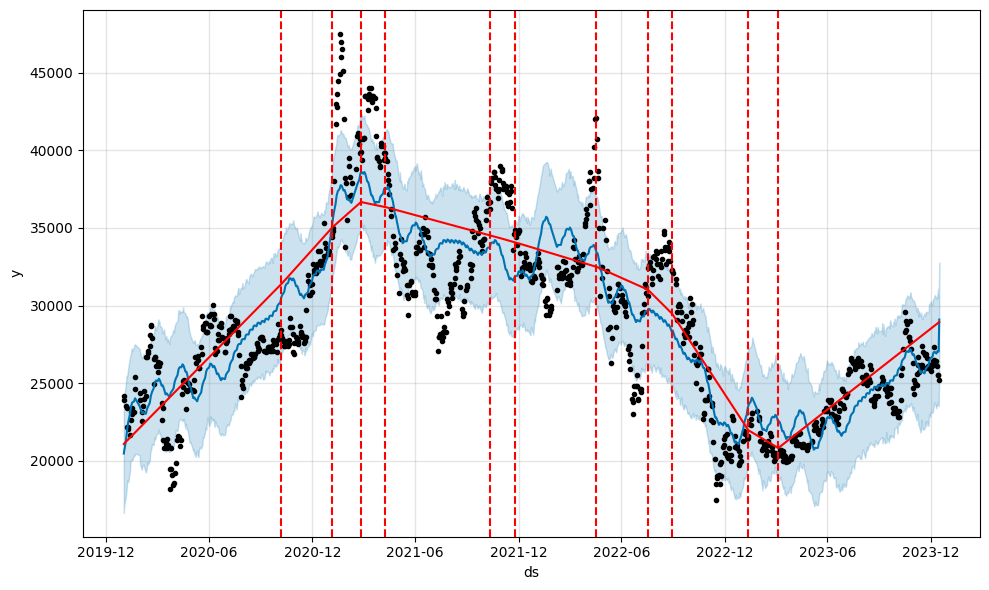

In [13]:
fig = prophet_m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),prophet_m , forecast)

### Hyperparameter tuning

In [14]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, initial='120 days', period='30 days', horizon='10 days' , parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

19:03:22 - cmdstanpy - INFO - Chain [1] start processing
19:03:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:03:54 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:04:19 - cmdstanpy - INFO - Chain [1] start processing
19:04:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:04:47 - cmdstanpy - INFO - Chain [1] start processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:05:07 - cmdstanpy - INFO - Chain [1] start processing
19:05:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has per

In [15]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

In [16]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.001,0.01,6375.825802
1,0.001,0.10,6594.303082
2,0.001,1.00,6951.414222
3,0.001,10.00,6865.670109
4,0.010,0.01,4573.002365
5,0.010,0.10,4727.325361
6,0.010,1.00,5008.785358
7,0.010,10.00,5117.777507
8,0.100,0.01,3602.606947
9,0.100,0.10,3775.850449


In [17]:
tuning_results = tuning_results.sort_values(by="rmse",ascending=False)
tuning_results['params'] = tuning_results.apply(lambda row: (row['changepoint_prior_scale'], row['seasonality_prior_scale']), axis=1)
# Create a bar plot using plotly.graph_objects
fig = go.Figure()

fig.add_trace(go.Bar(
    # not conver have wire error 
    x=tuning_results['params'].astype(str),
    y=tuning_results['rmse'],
    text=tuning_results['rmse'],
    hoverinfo='text',
    marker=dict(color='skyblue'),
))

# Customize the layout if needed
fig.update_layout(
    title=f'{stock_target} RMSE for Different ARIMA Parameter Sets',
    xaxis=dict(title='Parameter Sets', type='category'),
    yaxis=dict(title='RMSE'),
)

# Show the plot
fig.show()

In [18]:
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()] 
best_params

,changepoint_prior_scale,seasonality_prior_scale,rmse,params
12,0.5,0.01,2922.805695,"(0.5, 0.01)"


### Predict 

In [19]:
def move_day(today): 
    if today.weekday() == 5:  # Saturday
     today += timedelta(days=2)
    elif today.weekday() == 6:  # Sunday
     today += timedelta(days=1)
    return today

def generate_date_range(start_date, end_date):
    # mapping to stock is that day exist 
    df_map = stock_historical_data(symbol=stock_target, start_date=start_date.strftime('%Y-%m-%d'),end_date=end_date.strftime('%Y-%m-%d'), resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')
        
    return pd.to_datetime(df_map['time'])

def restore_df(X_scaler,y_scaler,scaler):

   num_features = 0
   # (number samples, number time steps, number features)
   if X_scaler.shape[1] == 1:
      num_features = X_scaler.shape[2]
   elif  X_scaler.shape[2] == 1:
      num_features = X_scaler.shape[1]  

   dummies = np.zeros((X_scaler.shape[0],num_features + 1))

   if  X_scaler.shape[1] == 1:
        # don't use timestep instead use features
       dummies[:,1:] = X_scaler.reshape((X_scaler.shape[0],X_scaler.shape[2]))
   elif X_scaler.shape[1] != 1:
       # use time steps
       dummies[:,1:] = X_scaler.reshape((X_scaler.shape[0],X_scaler.shape[1]))
   dummies[:, 0] = y_scaler.flatten()
   df = scaler.inverse_transform(dummies)
   return df

def get_predict_and_df(model, X, scaler):
    if not torch.is_tensor(X):
        X = torch.tensor(X).float() 
    
    with torch.no_grad():
       y_predicted = model(X.to(device)).to('cpu').numpy()
      
    y_predict = y_predicted.flatten()
    df = restore_df(X, y_predict, scaler)
    return df
   
def get_predict(model, X, scaler):
    with torch.no_grad():
      df = get_predict_and_df(model, X, scaler)
      return df[:,:1].reshape(df.shape[0])
    
def create_scaler_df(df):
     df_np = df.to_numpy()
     scaler = MinMaxScaler(feature_range = (0, 1))
     df_np_scaler = scaler.fit_transform(df_np)
     return df_np_scaler, scaler

def multi_scaler_df(df_list):
    df_np_scaler_list = []
    scaler_list = []
    for df in df_list:    
      df_np_scaler, scaler = create_scaler_df(df)
      df_np_scaler_list.append(df_np_scaler)
      scaler_list.append(scaler)
    return df_np_scaler_list, scaler_list

# def get_predict_next_day(model,scaler,shifted_df_as_np_scaler, lag=60):
#     X_predict_next_day = create_X_predict_next_day(shifted_df_as_np_scaler,lag) 
#     X = create_X_LSTM(X_predict_next_day)
#     y_predict = get_predict(model, X, scaler)[-1:]
#     return y_predict
    
# def create_X_LSTM(X):
#     X_flip = dc(np.flip(X, axis = 1))
#     X_flip_3D = X_flip.reshape((-1, lookback, 1))
#     return X_flip_3D
    
# def create_X_predict_next_day(shifted_df_as_np_scaler ,lag=60):
#     lag_X = shifted_df_as_np_scaler[-lag:,1:]
#     latest_X = shifted_df_as_np_scaler[-1:,:lookback]
#     return create_X_LSTM(np.append(lag_X,latest_X,axis=0))


In [20]:
day_test_range = generate_date_range(start_date,end_date)

In [21]:
len(day_test_range)

88

In [22]:
def get_list_next_day_actual_test_range():
    begin_day = (day_test_range.iloc[0] + timedelta(days=1)).strftime('%Y-%m-%d')
    stop_day = (day_test_range.iloc[-1] + timedelta(days=1)).strftime('%Y-%m-%d')
    df_raw = stock_historical_data(symbol=stock_target, start_date=begin_day,end_date=stop_day, resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')
    return df_raw


In [23]:
df_fw_list = []
print("Get stock data from origin data 2020-01-02 to latest test day "+ end_date.strftime('%Y-%m-%d'))
df_raw = stock_historical_data(symbol=stock_target, start_date=origin_start_date.strftime('%Y-%m-%d') ,end_date=end_date.strftime('%Y-%m-%d'), resolution="1D", type="stock", beautify=True, decor=False, source='DNSE')
df_fw_gen = pd.DataFrame()
df_fw_gen[['ds','y']] = df_raw[['time','close']]
df_fw_gen['ds'] = pd.to_datetime(df_fw_gen['ds'] )

for upper_bound_date in  day_test_range:
    df_fw = dc(df_fw_gen[ df_fw_gen['ds'] <= upper_bound_date])
    print(f"Create train set from {origin_start_date.strftime('%Y-%m-%d')} to {upper_bound_date.strftime('%Y-%m-%d')}")
    df_fw = df_fw.groupby('ds').mean().reset_index()
    df_fw_list.append(df_fw)

Get stock data from origin data 2020-01-02 to latest test day 2023-12-25
Create train set from 2020-01-02 to 2023-08-21
Create train set from 2020-01-02 to 2023-08-22
Create train set from 2020-01-02 to 2023-08-23
Create train set from 2020-01-02 to 2023-08-24
Create train set from 2020-01-02 to 2023-08-25
Create train set from 2020-01-02 to 2023-08-28
Create train set from 2020-01-02 to 2023-08-29
Create train set from 2020-01-02 to 2023-08-30
Create train set from 2020-01-02 to 2023-08-31
Create train set from 2020-01-02 to 2023-09-05
Create train set from 2020-01-02 to 2023-09-06
Create train set from 2020-01-02 to 2023-09-07
Create train set from 2020-01-02 to 2023-09-08
Create train set from 2020-01-02 to 2023-09-11
Create train set from 2020-01-02 to 2023-09-12
Create train set from 2020-01-02 to 2023-09-13
Create train set from 2020-01-02 to 2023-09-14
Create train set from 2020-01-02 to 2023-09-15
Create train set from 2020-01-02 to 2023-09-18
Create train set from 2020-01-02 t

In [24]:
my_df = df_fw_list[0]
my_df

,ds,y
0,2020-01-02,24177.0
1,2020-01-03,23890.0
2,2020-01-06,23508.0
3,2020-01-07,23412.0
4,2020-01-08,22170.0
...,...,...
903,2023-08-15,25100.0
904,2023-08-16,26200.0
905,2023-08-17,25900.0
906,2023-08-18,23900.0


Trainnng model

In [25]:
model_list = []

for df_fw in df_fw_list:
    prophet_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],seasonality_prior_scale=best_params['seasonality_prior_scale'])
    prophet_model.fit(df_fw)
    model_list.append(prophet_model)
    
model_list


c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\prophet\forecaster.py:125: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\prophet\forecaster.py:126: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

19:08:23 - cmdstanpy - INFO - Chain [1] start processing
19:08:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\prophet\forecaster.py:125: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\admin\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\prophet\forecaster.py:126: FutureWarning:

Calling float on a single element Series is deprecated and will 

In [26]:
def move_day(today): 
    if today.weekday() == 5:  # Saturday
     today += timedelta(days=2)
    elif today.weekday() == 6:  # Sunday
     today += timedelta(days=1)
    return today 

In [27]:
result = pd.DataFrame()
for  model in model_list:
     future = model.make_future_dataframe(periods=1)[-1:]
     forecast = model.predict(future)[['ds','yhat', 'yhat_lower', 'yhat_upper']]
     forecast['ds'] = forecast['ds'].apply(move_day)          
     result = pd.concat([result,forecast])


In [28]:
result

,ds,yhat,yhat_lower,yhat_upper
0,2023-08-22,26133.103114,24182.682970,28030.864738
0,2023-08-23,25988.068854,24111.360092,27889.225572
0,2023-08-24,25771.789553,23839.144815,27596.715022
0,2023-08-25,25621.694409,23691.934456,27696.269498
0,2023-08-28,25377.872386,23543.277011,27213.529110
...,...,...,...,...
0,2023-12-20,26560.147938,24461.979405,28640.776228
0,2023-12-21,26519.783166,24438.798456,28571.057329
0,2023-12-22,26425.495540,24375.908581,28398.867670
0,2023-12-25,26324.676326,24234.669492,28399.828065


In [29]:
y_actual = get_list_next_day_actual_test_range()
y_actual[['ds','y']] = y_actual[['time','close']]
y_actual = y_actual[['ds','y']]
y_actual['ds'] =  pd.to_datetime(y_actual['ds'])

In [30]:
y_actual

,ds,y
0,2023-08-22,23700
1,2023-08-23,23500
2,2023-08-24,24000
3,2023-08-25,24200
4,2023-08-28,24700
...,...,...
83,2023-12-20,25200
84,2023-12-21,25100
85,2023-12-22,25500
86,2023-12-25,25800


In [31]:
result = result.groupby('ds').mean().reset_index()

In [32]:
y_actual

,ds,y
0,2023-08-22,23700
1,2023-08-23,23500
2,2023-08-24,24000
3,2023-08-25,24200
4,2023-08-28,24700
...,...,...
83,2023-12-20,25200
84,2023-12-21,25100
85,2023-12-22,25500
86,2023-12-25,25800


In [33]:
compare_result = pd.concat([result.set_index('ds'),y_actual.set_index('ds')],axis=1)

In [34]:
compare_result

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2023-08-22,26133.103114,24182.682970,28030.864738,23700.0
2023-08-23,25988.068854,24111.360092,27889.225572,23500.0
2023-08-24,25771.789553,23839.144815,27596.715022,24000.0
2023-08-25,25621.694409,23691.934456,27696.269498,24200.0
2023-08-28,25377.872386,23543.277011,27213.529110,24700.0
...,...,...,...,...
2023-12-20,26560.147938,24461.979405,28640.776228,25200.0
2023-12-21,26519.783166,24438.798456,28571.057329,25100.0
2023-12-22,26425.495540,24375.908581,28398.867670,25500.0


In [35]:
compare_result = compare_result.dropna()
compare_result['y_change'] = compare_result['y'].diff()
compare_result['yhat_change'] = compare_result['yhat'].diff()
compare_result['y*yhat_chage'] = compare_result['y_change'] * compare_result['yhat_change']

C:\Users\admin\AppData\Local\Temp\ipykernel_9296\3965767302.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_9296\3965767302.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_9296\3965767302.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [36]:
import plotly.graph_objects as go

In [37]:
compare_result = compare_result.reset_index()

# Plotting with Plotly
fig = go.Figure()

# Plot yhat as a line
fig.add_trace(go.Scatter(x=compare_result['ds'], y=compare_result['yhat'], mode='lines+markers', name='yhat', line=dict(color='blue')))

# Plot the confidence interval
fig.add_trace(go.Scatter(x=compare_result['ds'].tolist() + compare_result['ds'].tolist()[::-1],
                         y=compare_result['yhat_upper'].tolist() + compare_result['yhat_lower'].tolist()[::-1],
                         fill='toself',
                         fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         name='95% CI'))

# Plot y as points
fig.add_trace(go.Scatter(x=compare_result['ds'], y=compare_result['y'], mode='lines+markers', name='y', marker=dict(color='red', size=8)))

# Set layout
fig.update_layout(title='VGI moving forward train and predict the next day with Prophet',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  showlegend=True)

# Show the plot
fig.show()

In [38]:
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(compare_result['y'], compare_result['yhat']))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate correlation coefficient
correlation = compare_result['y'].corr(compare_result['yhat'])
print(f"Correlation Coefficient: {correlation}")


r2 = r2_score(compare_result['y'], compare_result['yhat'])
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 1493.0683994197493
Correlation Coefficient: 0.3045531332909109
R-squared (R²): -0.0017886005557090634


In [40]:
df_mtr = pd.read_csv('./output/metrics-VGI.csv')
# remove old record
df_mtr = df_mtr[~(df_mtr['model'] == f'Prophet')]

df_mtr = pd.concat([df_mtr,
                    pd.DataFrame({
                     'model': ['Prophet'],
                     'rmse': [rmse],
                     'correlation': [correlation],
                     'r-squared': [r2] })], axis=0)
df_mtr.to_csv('./output/metrics-VGI.csv',index=False)

df_mtr

,model,rmse,r-squared,correlation
0,"ARIMA(9, 1, 9)",935.032698,0.824663,0.912103
2,"LSTM(1,4,1)",1268.217233,0.321006,0.634703
0,Prophet,1493.068399,-0.001789,0.304553


In [41]:
compare_result = compare_result.dropna()

In [42]:
truth = []

for y_hat_change, y_change in zip(compare_result['yhat'].diff().dropna(),compare_result['y'].diff().dropna()):
    truth.append(1 if y_hat_change * y_change > 0 else 0)

print(f"Direction correction ratio: {np.sum(truth)/len(truth) * 100}")

Direction correction ratio: 39.285714285714285


In [43]:
moving_arr = compare_result['yhat'].diff().dropna()  * compare_result['y'].diff().dropna()
marker_colors = ['red' if value < 0 else 'green' for value in moving_arr]

trace = go.Scatter(x=np.arange(len(moving_arr)), y=moving_arr, mode='lines+markers', name='Result Array', marker=dict(color=marker_colors))


# Create layout
layout = go.Layout(title='Line with Markers for Result Array', xaxis=dict(title='Index'), yaxis=dict(title='Value'))

# Create figure and add trace
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [44]:
compare_result['y_rolling_7_std'] = compare_result['y_change'].rolling(window=7).std()
compare_result['yhat_rolling_7_std'] = compare_result['yhat_change'].rolling(window=7).std()
compare_result['y*yhat_chage_rolling_7'] =  compare_result['y*yhat_chage'].rolling(window=7).mean()
compare_result['moving_corr'] = compare_result['y*yhat_chage_rolling_7'] / (compare_result['y_rolling_7_std'] * compare_result['yhat_rolling_7_std'])

In [45]:
import plotly.express as px
# Here we use a column with categorical data
fig = px.histogram(compare_result['moving_corr'], nbins=60)
fig.show()

### Hybrid FB-Prophet and LSTM 

We use the predict and it's 3 lags result from Prophet as input features to LSTM and the target variables still the stock price. The reason is that LSTM can capture some pattern Prophet may be miss

In [46]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]


In [47]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first = True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [48]:
def create_predict_list():
     predict_list = []
     for  model, df  in zip(model_list, df_fw_list):
      future = model.make_future_dataframe(periods=0)
      forecast = model.predict(future)[['ds','yhat', 'yhat_lower', 'yhat_upper']]
      forecast['ds'] = forecast['ds'].apply(move_day)  
      forecast['y'] = df['y']
      predict_list.append(forecast)     
     return predict_list

In [49]:
df_predict_list = create_predict_list()

In [50]:
df_predict_list[0]

,ds,yhat,yhat_lower,yhat_upper,y
0,2020-01-02,21252.484187,19308.916966,23102.719222,24177.0
1,2020-01-03,21533.881189,19538.962831,23528.008387,23890.0
2,2020-01-06,22127.044591,20321.807058,23977.566243,23508.0
3,2020-01-07,22506.300182,20612.544354,24336.621792,23412.0
4,2020-01-08,22821.461534,20817.638820,24765.083163,22170.0
...,...,...,...,...,...
903,2023-08-15,26008.500474,23868.611279,27866.809186,25100.0
904,2023-08-16,26104.727631,24203.624025,28110.561130,26200.0
905,2023-08-17,26116.445151,24110.088268,28012.941149,25900.0
906,2023-08-18,26180.795293,24094.161081,28100.447988,23900.0


In [51]:
LSTM_loop_back=3
LSTM_lstm_input_cols = ['y','yhat']
LSTM_resid_loop_back = 2

shifted_df_LSTM_list = []

def prepare_dataframe_grach_for_lstm(df, n_steps, resid_loop_back):
  df = dc(df)[LSTM_lstm_input_cols]
  for i in range(1, n_steps + 1):
    df[f'yhat(t-{i})'] = df['yhat'].shift(i)
  for i in range(1,resid_loop_back+1):
      df[f'resid(t-{i})'] = (df['y'] - df['yhat']).shift(i)

  return df

for df in df_predict_list:
   shifted_df  = prepare_dataframe_grach_for_lstm(df,LSTM_loop_back,LSTM_resid_loop_back)
   shifted_df_LSTM_list.append(shifted_df)


In [52]:
shifted_df_LSTM_list[0]

,y,yhat,yhat(t-1),yhat(t-2),yhat(t-3),resid(t-1),resid(t-2)
0,24177.0,21252.484187,NaN,NaN,NaN,NaN,NaN
1,23890.0,21533.881189,21252.484187,NaN,NaN,2924.515813,NaN
2,23508.0,22127.044591,21533.881189,21252.484187,NaN,2356.118811,2924.515813
3,23412.0,22506.300182,22127.044591,21533.881189,21252.484187,1380.955409,2356.118811
4,22170.0,22821.461534,22506.300182,22127.044591,21533.881189,905.699818,1380.955409
...,...,...,...,...,...,...,...
903,25100.0,26008.500474,25844.247399,25852.930045,25752.204599,-544.247399,-752.930045
904,26200.0,26104.727631,26008.500474,25844.247399,25852.930045,-908.500474,-544.247399
905,25900.0,26116.445151,26104.727631,26008.500474,25844.247399,95.272369,-908.500474
906,23900.0,26180.795293,26116.445151,26104.727631,26008.500474,-216.445151,95.272369


In [53]:
scaler_LSTM_input_list, scaler_LSTM_list = multi_scaler_df([df_shifted.dropna() for df_shifted in shifted_df_LSTM_list])

In [54]:
scaler_LSTM_input_list[0]

array([[0.19706667, 0.11471831, 0.09813632, ..., 0.0598984 , 0.58813519,
        0.66056158],
       [0.15566667, 0.12849794, 0.11471831, ..., 0.07220177, 0.55283747,
        0.58813519],
       [0.15566667, 0.13865974, 0.12849794, ..., 0.09813632, 0.4371855 ,
        0.55283747],
       ...,
       [0.28      , 0.27256271, 0.27205039, ..., 0.26066155, 0.49264619,
        0.41809495],
       [0.21333333, 0.27537625, 0.27256271, ..., 0.2678431 , 0.46949461,
        0.49264619],
       [0.21666667, 0.26861547, 0.27537625, ..., 0.27205039, 0.3161732 ,
        0.46949461]])

In [55]:
X_list = []
y_list = []

for shifted_df_scaler in scaler_LSTM_input_list:
    X = shifted_df_scaler[:, 1:]
    y = shifted_df_scaler[:, 0:1]
    X_list.append(X)
    y_list.append(y)

In [56]:
X_train_list = [X_train.reshape((-1, 1, LSTM_loop_back+ 1 + LSTM_resid_loop_back)) for X_train in X_list]
y_train_list =  [y_train.reshape((-1, 1)) for y_train in y_list]

In [57]:
X_train_list = [torch.tensor(X_train).float() for X_train in X_train_list]
y_train_list = [torch.tensor(y_train).float() for y_train in y_train_list]

X_train_list[0].shape, y_train_list[0].shape

(torch.Size([905, 1, 6]), torch.Size([905, 1]))

In [58]:
train_dataset_list = [TimeSeriesDataset(X_train, y_train) for X_train, y_train in zip(X_train_list,y_train_list)]

In [59]:
from torch.utils.data import DataLoader
batch_size = 12

train_loader_list = [DataLoader(train_dataset, batch_size = batch_size, shuffle = True) for train_dataset in train_dataset_list ]

In [60]:
train_loader_list[0]

Init LSTM model 6,4,1

In [61]:
list_LSTM_model = []

for i in range(len(train_loader_list)):
  m = LSTM(6, 4, 1) #1,4,1 19:30
  m.to(device)
  list_LSTM_model.append(m)

list_LSTM_model[0]

LSTM(
  (lstm): LSTM(6, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [62]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()

def train_one_epoch(model,train_loader,epoch):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  model.train(True)
  print(f'Epoch: {epoch + 1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 20 == 10: # print every 10 batches
        avg_loss_across_batches = running_loss / 1
        print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                              avg_loss_across_batches))
        running_loss = 0.0
  print()

In [63]:
for model, train_loader in zip(list_LSTM_model,train_loader_list):
  for epoch in range(num_epochs):
    train_one_epoch(model=model,train_loader=train_loader,epoch=epoch)

Epoch: 1
Batch 11, Loss: 4.098
Batch 31, Loss: 6.791
Batch 51, Loss: 5.925
Batch 71, Loss: 4.487

Epoch: 2
Batch 11, Loss: 1.903
Batch 31, Loss: 3.162
Batch 51, Loss: 2.086
Batch 71, Loss: 1.152

Epoch: 3
Batch 11, Loss: 0.495
Batch 31, Loss: 0.547
Batch 51, Loss: 0.423
Batch 71, Loss: 0.323

Epoch: 4
Batch 11, Loss: 0.160
Batch 31, Loss: 0.276
Batch 51, Loss: 0.211
Batch 71, Loss: 0.169

Epoch: 5
Batch 11, Loss: 0.081
Batch 31, Loss: 0.135
Batch 51, Loss: 0.101
Batch 71, Loss: 0.077

Epoch: 6
Batch 11, Loss: 0.038
Batch 31, Loss: 0.041
Batch 51, Loss: 0.058
Batch 71, Loss: 0.039

Epoch: 7
Batch 11, Loss: 0.022
Batch 31, Loss: 0.035
Batch 51, Loss: 0.042
Batch 71, Loss: 0.030

Epoch: 8
Batch 11, Loss: 0.015
Batch 31, Loss: 0.045
Batch 51, Loss: 0.035
Batch 71, Loss: 0.028

Epoch: 9
Batch 11, Loss: 0.017
Batch 31, Loss: 0.040
Batch 51, Loss: 0.029
Batch 71, Loss: 0.028

Epoch: 10
Batch 11, Loss: 0.019
Batch 31, Loss: 0.028
Batch 51, Loss: 0.031
Batch 71, Loss: 0.027

Epoch: 11
Batch 11,

In [80]:
my_df = df_fw_list[0].reset_index()


fig = go.Figure()

actual_scat = go.Scatter(x=my_df['ds'][LSTM_loop_back:], y=my_df['y'][LSTM_loop_back:], mode='lines', name="Actual Price y", line=dict(color='red'))

# get predict
predicted = get_predict(model=list_LSTM_model[0],X=X_train_list[0], scaler=scaler_LSTM_list[0])
# plot it
predicted_scat = go.Scatter(x=my_df['ds'][LSTM_loop_back:], y=predicted, mode='lines', name="Prophet-LSTM Predic t Price yhat", line=dict(color='blue'))

prop_predicted_scat = go.Scatter(x=my_df['ds'][LSTM_loop_back:], y=df_predict_list[0]['yhat'][LSTM_loop_back:], mode='lines', name="Prophet ", line=dict(color='green'))


fig.add_trace(actual_scat)
fig.add_trace(prop_predicted_scat)
fig.add_trace(predicted_scat)
fig.update_layout(title_text=f'{stock_target} a random horizon in samples predict')
       

In [65]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(my_df['y'][LSTM_loop_back:], predicted)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Prophet-LSTM Root Mean Squared Error (RMSE): {rmse}")

print(f"Correlation: {np.corrcoef(my_df['y'][LSTM_loop_back:], predicted)[0,1]}")

Prophet-LSTM Root Mean Squared Error (RMSE): 1009.855781720656
Correlation: 0.9854370003387537


In [66]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(my_df['y'][LSTM_loop_back:], df_predict_list[0]['yhat'][LSTM_loop_back:])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Prophet Root Mean Squared Error (RMSE): {rmse}")
print(f"Correlation: {np.corrcoef(my_df['y'][LSTM_loop_back:],  df_predict_list[0]['yhat'][LSTM_loop_back:])[0,1]}")

Prophet Root Mean Squared Error (RMSE): 1512.540833509499
Correlation: 0.9671577093846787


#### Moving Forward Predict for Prophet-LSTM

In [67]:
shifted_df_LSTM_list[0]

,y,yhat,yhat(t-1),yhat(t-2),yhat(t-3),resid(t-1),resid(t-2)
0,24177.0,21252.484187,NaN,NaN,NaN,NaN,NaN
1,23890.0,21533.881189,21252.484187,NaN,NaN,2924.515813,NaN
2,23508.0,22127.044591,21533.881189,21252.484187,NaN,2356.118811,2924.515813
3,23412.0,22506.300182,22127.044591,21533.881189,21252.484187,1380.955409,2356.118811
4,22170.0,22821.461534,22506.300182,22127.044591,21533.881189,905.699818,1380.955409
...,...,...,...,...,...,...,...
903,25100.0,26008.500474,25844.247399,25852.930045,25752.204599,-544.247399,-752.930045
904,26200.0,26104.727631,26008.500474,25844.247399,25852.930045,-908.500474,-544.247399
905,25900.0,26116.445151,26104.727631,26008.500474,25844.247399,95.272369,-908.500474
906,23900.0,26180.795293,26116.445151,26104.727631,26008.500474,-216.445151,95.272369


In [68]:
def create_X_LSTM(X, scaler, number_features):
    X = np.atleast_2d(np.array(X))
    yX = np.atleast_2d(np.append(np.zeros((X.shape[0], 1)),X))
    yX_scaler = scaler.transform(yX)
    X_3D = yX_scaler[:,1:].reshape((-1, 1, number_features))
    return X_3D


def create_X_predict_next_day(prophet_model, shifted_df_LSTM):
    future = prophet_model.make_future_dataframe(periods=1)
    forecast = prophet_model.predict(future)[['ds','yhat']]
    # get the current yhat -> yhat(t - LSTM_loop_back -1) total is LSTM_loop_back
    lag_yhat = shifted_df_LSTM.iloc[-1:,1:1+LSTM_loop_back]
    # skip oldest yhat cols and get from latest reisd to oldest resid - 1
    lag_resid = shifted_df_LSTM.iloc[-1:, 1+ LSTM_loop_back + 1: -1]
    current_reisd = (shifted_df_LSTM[-1:]['y'] - shifted_df_LSTM[-1:]['yhat'])
    next_yhat = forecast['yhat'][-1:]
    #return create_X_LSTM(np.append(lag_X,latest_X,axis=0))
    merge_X = np.concatenate((np.array(next_yhat).flatten(),np.array(lag_yhat).flatten(),np.array(current_reisd).flatten(),np.array(lag_resid).flatten()),axis=0)
    return merge_X

def get_predict_next_day(LSTM_model,scaler,prophet_model,shifted_df_LSTM):
    X_predict_next_day = create_X_predict_next_day(prophet_model,shifted_df_LSTM) 
    X_scaler = create_X_LSTM(X_predict_next_day, scaler, LSTM_loop_back + 1 + LSTM_resid_loop_back)
    y_predict_next_day = get_predict(LSTM_model, X_scaler, scaler)[-1:]
    return y_predict_next_day[0]


In [69]:
def get_list_next_day_predict_test_range():
    next_days = []
    for LSTM_model, scaler, prophet_model, shifted_df_LSTM  in zip(list_LSTM_model, scaler_LSTM_list, model_list, shifted_df_LSTM_list):
      next_day_predict = get_predict_next_day(model, scaler, prophet_model, shifted_df_LSTM)
      next_days.append(next_day_predict)
    return np.array(next_days).reshape(len(next_days))



def create_evalute_table():
    next_days = get_list_next_day_predict_test_range()
    df = get_list_next_day_actual_test_range()
    df['predict'] = pd.Series(next_days)
    df[['ds','y','yhat']] = df[['time','close','predict']]
    df = df[['ds','y','yhat']]
    df['ds'] = pd.to_datetime(df['ds'])
    return df

In [70]:
get_list_next_day_actual_test_range()

,time,open,high,low,close,volume,ticker
0,2023-08-22,24000,24200,22500,23700,565100,VGI
1,2023-08-23,23500,24000,23500,23500,173900,VGI
2,2023-08-24,23400,24000,23400,24000,261600,VGI
3,2023-08-25,27000,27000,23600,24200,551100,VGI
4,2023-08-28,24600,24800,24000,24700,344200,VGI
...,...,...,...,...,...,...,...
83,2023-12-20,25000,25300,25000,25200,348300,VGI
84,2023-12-21,25200,25300,25000,25100,178000,VGI
85,2023-12-22,25300,25700,25300,25500,425400,VGI
86,2023-12-25,25500,25900,25500,25800,411000,VGI


In [72]:
df_eval = create_evalute_table()
df_eval['y_change'] = df_eval['y'].diff()
df_eval['yhat_change'] = df_eval['yhat'].diff()
df_eval['y*yhat_chage'] = df_eval['y_change'] * df_eval['yhat_change']

In [73]:
df_eval

,ds,y,yhat,y_change,yhat_change,y*yhat_chage
0,2023-08-22,23700,24477.064908,NaN,NaN,NaN
1,2023-08-23,23500,24290.851206,-200.0,-186.213702,37242.740393
2,2023-08-24,24000,24134.633988,500.0,-156.217217,-78108.608723
3,2023-08-25,24200,24331.609607,200.0,196.975619,39395.123720
4,2023-08-28,24700,24560.386837,500.0,228.777230,114388.614893
...,...,...,...,...,...,...
83,2023-12-20,25200,25058.492720,200.0,20.941794,4188.358784
84,2023-12-21,25100,25206.746459,-100.0,148.253739,-14825.373888
85,2023-12-22,25500,25264.776051,400.0,58.029592,23211.836815
86,2023-12-25,25800,25381.615758,300.0,116.839707,35051.912069


In [76]:
from sklearn.metrics import r2_score

In [77]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate correlation coefficient
correlation = df_eval['y'].corr(df_eval['yhat'])
print(f"Correlation Coefficient: {correlation}")

truth = []
for y_hat_change, y_change in zip(df_eval['yhat'].diff().dropna(),df_eval['y'].diff().dropna()):
    truth.append(1 if y_hat_change * y_change > 0 else 0)


print(f"Direction correction ratio: {np.sum(truth)/len(truth) * 100}")


r2 = r2_score(df_eval['y'], df_eval['yhat'])
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 776.4213712564484
Correlation Coefficient: 0.8697644923372456
Direction correction ratio: 44.827586206896555
R-squared (R²): 0.7455081723711081


In [78]:
df_mtr = pd.read_csv('./output/metrics-VGI.csv')
# remove old record
df_mtr = df_mtr[~(df_mtr['model'] == 'Prophet-LSTM')]

df_mtr = pd.concat([df_mtr,
                    pd.DataFrame({
                     'model': ['Prophet-LSTM'],
                     'rmse': [rmse],
                     'correlation': [correlation],
                     'r-squared': [r2] })], axis=0)
df_mtr.to_csv('./output/metrics-VGI.csv',index=False)

In [81]:
# Plotting with Plotly
fig = go.Figure()

# Plot yhat as a line
fig.add_trace(go.Scatter(x=df_eval['ds'], y=df_eval['yhat'], mode='lines+markers', name='yhat', line=dict(color='blue')))

# Plot y as points
fig.add_trace(go.Scatter(x=df_eval['ds'], y=df_eval['y'], mode='lines+markers', name='y', marker=dict(color='red', size=8)))

# Set layout
fig.update_layout(title='VGI moving forward train and predict the next day with Prophet-LSTM',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  showlegend=True)

# Show the plot
fig.show()